# Cisterne Evaluation

In [1]:
!pip install search-relevance-eval

Looking in indexes: https://pypi.org/simple, https://artifactory.dbc.dk/artifactory/api/pypi/pypi-dbc/simple
You should consider upgrading via the '/home/jsj/dev/repos/ai/simple-search/env/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import simple_search.evaluation
from IPython.display import display, Image

%matplotlib inline

In [3]:
data_path = '../../seca2019'



## Serenas Projekt

På baggrund af Randers top-1000 søgninger har vi genskant top-100 resultater for alle søgningerne.
Serena har lavet et testsæt ved at vælge en række af disse søgninger ud, og manuelt vurdere resultaternes relevans i forhold til hver enkelt søgning.

[link til oversigt over søgesæt](https://docs.google.com/spreadsheets/d/e/2PACX-1vQT27agJizpazC7EEgn9AHxDQdKGhPDBXFBc-ka5YKOJh5VxOWoEuEzF2llYTKyxPv3b0KK3x0AL4lj/pub?output=csv)

Søgesættet kan også findes på [gitlab](https://gitlab.dbc.dk/ai/seca2019)

### Eksempel på evaluerings ark

In [4]:
df = pd.read_csv(f"{data_path}/search-evaluations/harry potter.csv")
df.head()

,Unnamed: 0,title,link,creator,emneord,årstal,sprog,materialetype,rating,query,pid,dk5,query_number,res#
0,0,Hanging in judgment : Religion and the death p...,https://bibliotek.dk/da/work/820030-katalog:24...,Harry Potter,NaN,1993,eng,Bog,0.5,harry potter,820030-katalog:246833,NaN,1,1
1,1,Harry Pottcast & Hemmelighedernes Kammer,https://bibliotek.dk/da/work/870970-basis:4685...,NaN,"engelsk litteratur, troldmænd, Engelsk littera...",2019,dan,Lyd (podcast),1,harry potter,870970-basis:46851196,81.3,1,2
2,2,Harry Pottcast & De Vises Sten,https://bibliotek.dk/da/work/870970-basis:4677...,NaN,"mystik, Engelsk litteraturhistorie, magi, Joan...",2019,dan,Lyd (podcast),NaN,harry potter,870970-basis:46774604,81.3,1,3
3,3,Harry Pottcast & De Vises Sten,https://bibliotek.dk/da/work/870970-basis:4677...,NaN,"mystik, Engelsk litteraturhistorie, magi, Joan...",2019,dan,Lyd (podcast),NaN,harry potter,870970-basis:46774493,81.3,1,4
4,4,Harry Pottcast & Hemmelighedernes Kammer,https://bibliotek.dk/da/work/870970-basis:4685...,NaN,"engelsk litteratur, troldmænd, Engelsk littera...",2019,dan,Lyd (podcast),\n,harry potter,870970-basis:46851293,81.3,1,5


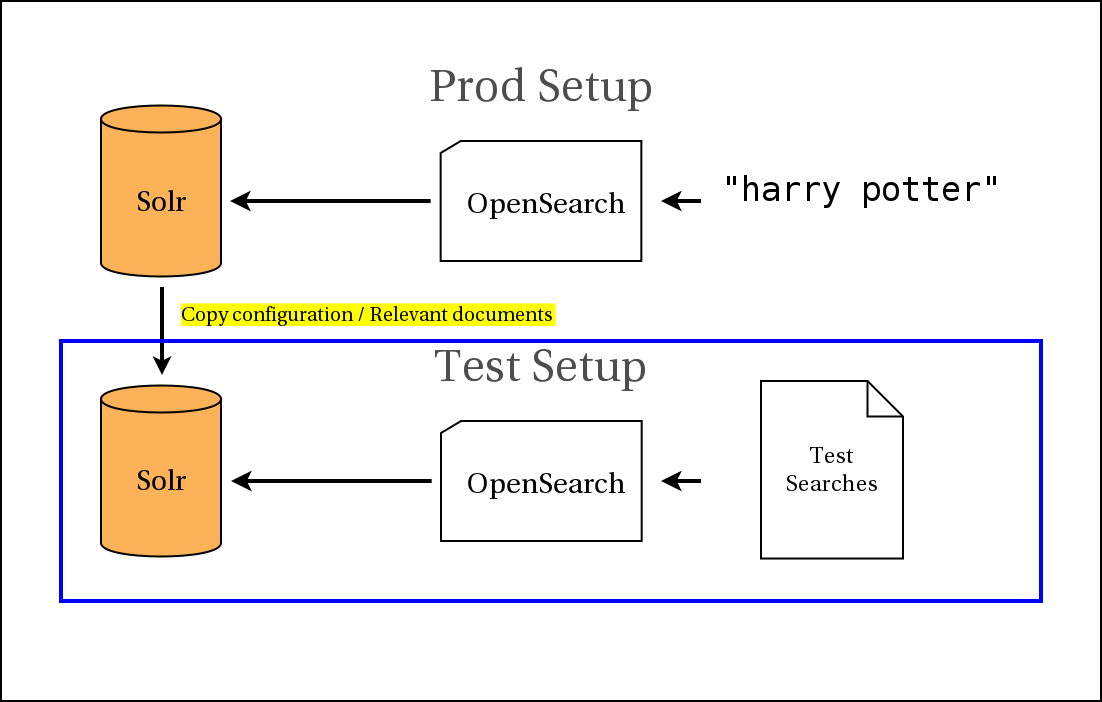

In [5]:
display(Image(filename='images/test-setup.png'))

## Test opsætning

Test opsætningen består af følgende dele:

* Solr  
  - Solr'en er baseret på DBCs dockerimage, og ved deploy bliver konfigurationen fra cisterne kopieret, så kopien har samme indekser og opførsel i test som i drift.
  - Efter start af solr'en bliver relevante dokumenter kopieret.  
    For hvert pid i testsættet bliver værket identificeret, og alle solrdokumenter med en reference til værket bliver fundet og kopieret.
* OpenSearch  
  En OpenSearch instans der peger på test-solr'en

  
# Metrikker

## precision

Precision er den fraktion af dokumenter i søgeresultatet der er relevante.

$$\frac{|\{relevant\;documents\} \cap \{retrieved\:documents\}|}{|\{retreived\;documents\}|}$$


## recall
Recall er den fraktion af relevante resultater der er returneret i søgeresultatet.

$$\frac{|\{relevant\;documents\} \cap \{retrieved\:documents\}|}{|\{relevant\;documents\}|}$$

## f-measure

f-measure er en kombination af precision og recall (harmoniske gennemsnit).

$$\frac{precision \cdot recall}{precision + recall}$$


## DCG og nDCG

_Discounted Cumulative Gain_ og _Normalized Discounted Cumulative Gain_ Er en måde at måle kvaliteten af rankering (nDCG er normaliseret og kan bruges til at sammenligne på tværs af søgninger/testsæt odv).

### CG (Cumulative Gain)
_Cumulative Gain_ er summen af evaluaringerne for et givent søgeresultat og tager ikke højde for rankeringen i resultatet.

$$CG_p = \sum_{i=1}^p rel_i$$

### DCG

_Discounted Cumulative Gain_ tager højde for ordenen af søgeresultatet. Relevante dokumenter der ligger længere ned i søgeresultatet får en lavere værdi en et tilsvarende dokument i toppen. Dokumenterne relevans bliver reduceret logarimisk propertionelt med deres position i søgelisten.

$$DCG_p = \sum_{i=1}^p \frac{rel_i}{log_2(i+1)}$$

### Normalized DCG

Da længden af søgeresultatet afhænger af søgningen kan man ikke sammenligne _DCG_ på tværs af forskellige søgninger. For at kunne gøre dette normaliseres _DCG_ ved at dividere værdien med det optimale søgeresultat _Ideal DCG_ (_IDCG_).
Det optimale søgeresultat laves ved at sortere samtlige relevante dokumenter for søgningen og tage de top-p mest relevante. Herefter kan _nDCG_ udregnes:

$$nDCG_p \frac{DCG_p}{IDCG_p}$$

hvor _IDCG_ er:

$$IDCG_p = \sum_{i=1}^{|REL_p|} \frac{2^{rel_i}-1}{log_2(i+1)}$$

og $REL_p$ er den sorterede liste af de mest relevante resultater.

# Resultater

In [6]:
url = "http://simple-search-bibdk-1-0.mi-prod.svc.cloud.dbc.dk/search"
search_results, search_test_dfs = simple_search.evaluation.perform_search(data_path,
    lambda q: simple_search.evaluation.simple_search(url, q))
search_ratings = simple_search.evaluation.get_ratings(search_test_dfs)

0it [00:00, ?it/s]

Q <function <lambda> at 0x7f12ae983ee0>


77it [00:23,  3.22it/s]


In [7]:
search_results.head(10)

,query,precision,recall,f-measure,nDCG
0,harry potter,0.6,0.6,0.6,0.553265
1,lucinda riley,0.6,0.6,0.6,0.500263
2,jeffrey archer,0.6,0.6,0.6,0.557488
3,leonora christina skov,0.6,0.6,0.6,0.600945
4,"den, der lever stille",0.2,0.2,0.2,0.360779
5,dødevaskeren,0.6,0.6,0.6,0.773653
6,sense,0.6,0.6,0.6,0.753192
7,k for klara,0.0,0.0,0.0,0.000000
8,alt for damerne,0.4,0.4,0.4,0.489358
9,femina,0.0,0.0,0.0,0.000000


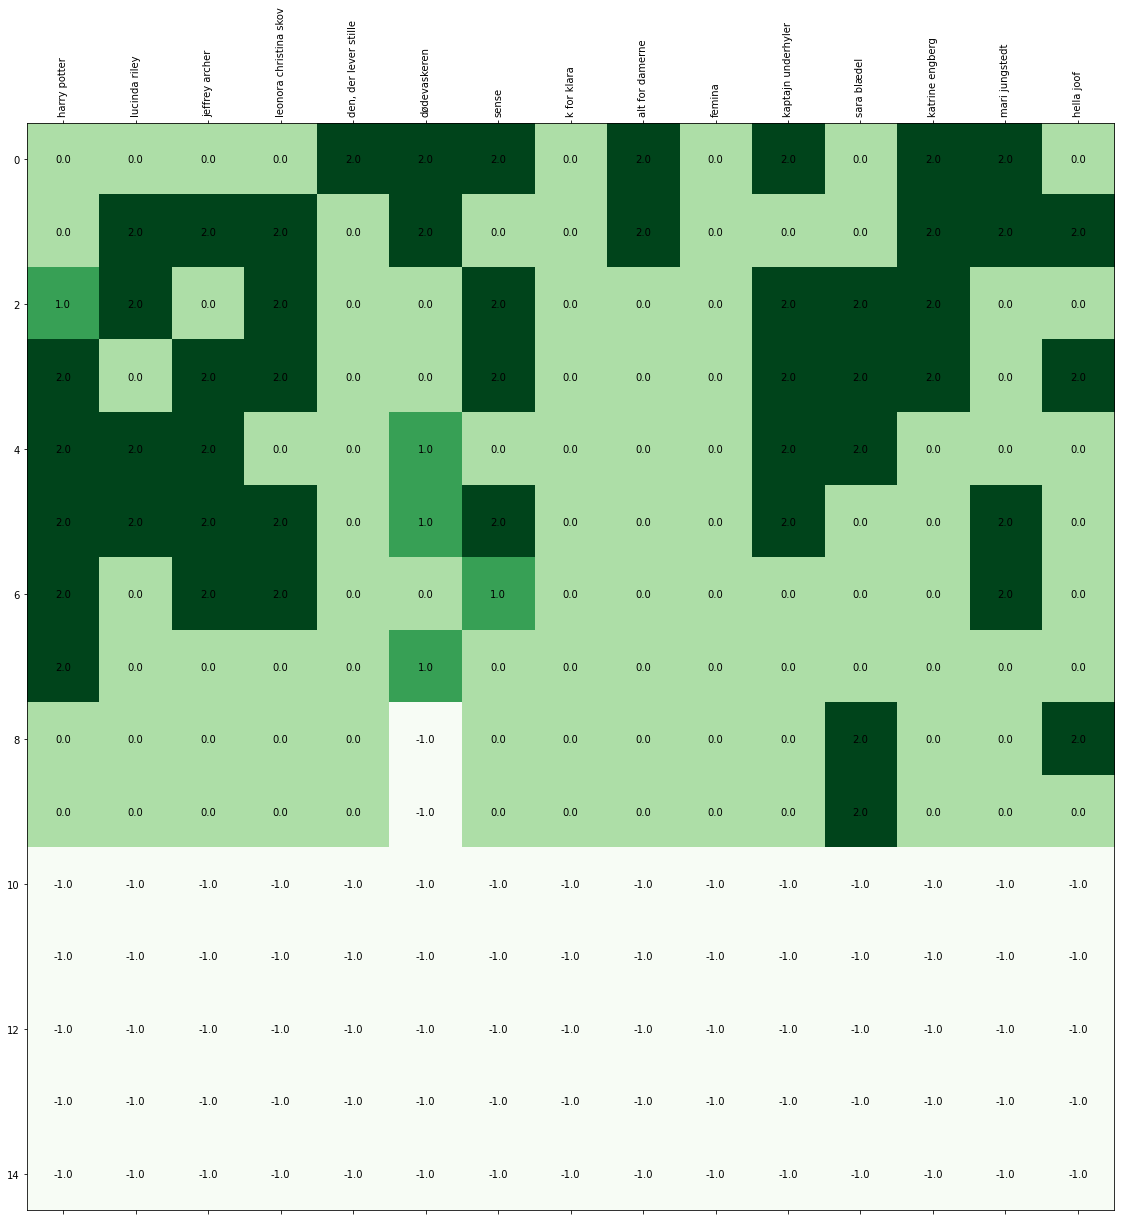

In [8]:
simple_search.evaluation.show_subset(search_ratings, search_results)
plt.show()

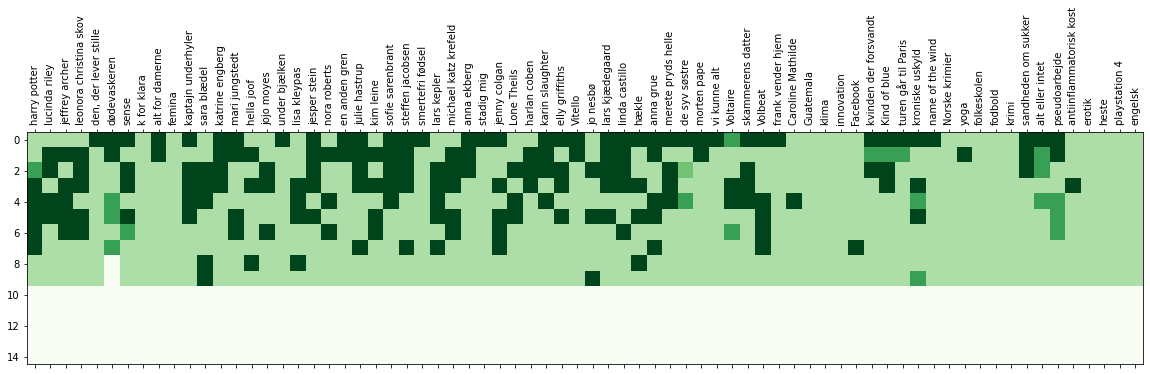

In [9]:
simple_search.evaluation.show_all(search_ratings, search_results)
plt.show()